<a href="https://colab.research.google.com/github/e050110/collab/blob/master/synthetic_features_and_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Caractéristiques synthétiques et anomalies

 **Objectifs d'apprentissage :**
  * Créer une caractéristique synthétique qui est le ratio de deux autres caractéristiques
  * Utiliser cette nouvelle caractéristique comme entrée dans un modèle de régression linéaire
  * Améliorer l'efficacité du modèle en identifiant et en éliminant les anomalies des données d'entrée

 Reprenons le modèle utilisé dans l'exercice "Premiers pas avec TensorFlow". 

Vous allez, tout d'abord, importer les données sur l'immobilier en Californie dans un `DataFrame` *Pandas* :

 ## Configuration

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3813,-117.9,33.8,26.0,1589.0,259.0,735.0,315.0,4.6,243.2
7405,-118.3,34.0,46.0,3402.0,503.0,1389.0,504.0,5.3,270.4
6904,-118.3,36.9,35.0,2563.0,530.0,861.0,371.0,2.3,80.6
13299,-121.9,37.5,7.0,28258.0,3864.0,12203.0,3701.0,8.4,451.1
12187,-121.5,38.6,14.0,3167.0,551.0,1787.0,533.0,3.8,92.6
...,...,...,...,...,...,...,...,...,...
12206,-121.5,38.5,29.0,3873.0,797.0,2237.0,706.0,2.2,72.1
744,-117.1,34.0,33.0,1575.0,326.0,879.0,282.0,2.5,94.4
16480,-122.6,38.1,14.0,2259.0,341.0,1127.0,346.0,6.4,334.9
8136,-118.4,34.1,31.0,1856.0,425.0,795.0,426.0,2.8,360.6


 Vous allez ensuite configurer la fonction d'entrée et la définir pour l'entraînement de modèle :

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

 ## Tâche 1 : Essayer une caractéristique synthétique

Les caractéristiques `total_rooms` et `population` comptabilisent les totaux d'un îlot urbain donné.

Mais que se passe-t-il si un îlot urbain est plus densément peuplé qu'un autre ? Vous pouvez étudier la relation entre la densité de population et le prix médian des logements en créant une caractéristique synthétique qui est un ratio de `total_rooms` et `population`.

Dans la cellule ci-dessous, créez une caractéristique nommée `rooms_per_person` et utilisez-la comme `input_feature` pour `train_model()`.

Quelles sont les meilleures performances qu'il est possible d'obtenir avec cette seule caractéristique en réglant le taux d'apprentissage ? (Plus les performances sont élevées, mieux la droite de régression devrait ajuster les données et plus la valeur RMSE finale devrait être basse.)

 **REMARQUE **: Vous jugerez peut-être utile d'ajouter quelques cellules de code ci-dessous afin d'essayer différents taux d'apprentissage et de comparer les résultats. Pour ajouter une nouvelle cellule de code, passez la souris sous le centre de cette cellule, puis cliquez sur **CODE**.

In [5]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] =

calibration_data = train_model(
    learning_rate=0.00005,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

SyntaxError: ignored

 ### Solution

Cliquez ci-dessous pour afficher une solution.


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 213.29
  period 01 : 191.85
  period 02 : 171.66
  period 03 : 154.38
  period 04 : 141.74
  period 05 : 135.30
  period 06 : 131.51
  period 07 : 130.54
  period 08 : 131.06
  period 09 : 132.21
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,198.8,207.3
std,91.3,116.0
min,45.5,15.0
25%,163.0,119.4
50%,195.7,180.4
75%,223.6,265.0
max,4358.2,500.0


Final RMSE (on training data): 132.21


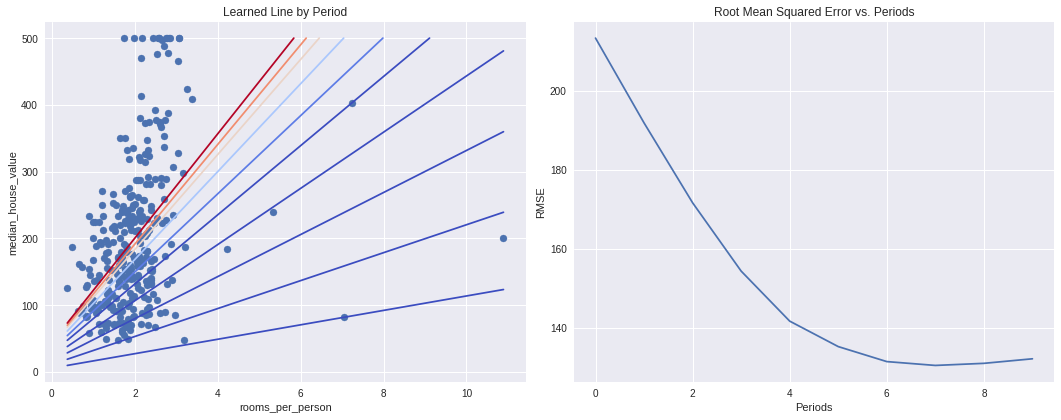

In [6]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

 ## Tâche 2 : Identifier les anomalies

Vous pouvez visualiser les performances du modèle en créant un diagramme de dispersion des prédictions par rapport aux valeurs cibles. Idéalement, elles doivent se trouver sur une ligne diagonale parfaitement corrélée.

Utilisez la fonction `scatter()` de Pyplot pour créer un diagramme de ce type, en utilisant le modèle "pièces par personne" que vous avez entraîné dans le cadre de la Tâche 1.

Constatez-vous des anomalies ? Remontez jusqu'aux données source en observant la répartition des valeurs dans le modèle `rooms_per_person`.

In [0]:
# YOUR CODE HERE

 ### Solution

Cliquez ci-dessous pour afficher la solution.

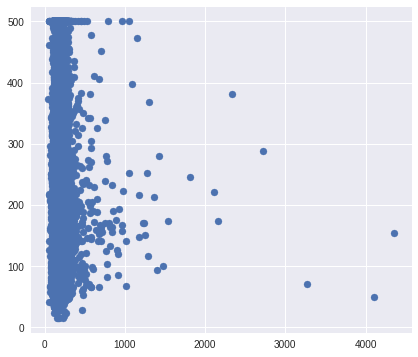

In [7]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

 Les données de calibrage montrent un alignement de la plupart des points de dispersion. La ligne est pratiquement verticale (mais nous y reviendrons). Concentrez-vous, pour le moment, sur les points qui s'écartent de la ligne. Vous remarquerez qu'ils sont relativement peu nombreux.

Si vous représentez graphiquement un histogramme du modèle `rooms_per_person`, vous constatez que les données d'entrée présentent quelques anomalies :

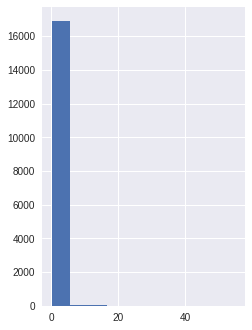

In [8]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

 ## Tâche 3 : Éliminer les anomalies

Voyons s'il est possible d'améliorer encore l'ajustement du modèle en remplaçant les valeurs aberrantes de `rooms_per_person` par des valeurs minimales ou maximales raisonnables.

Voici un exemple qui illustre l'application d'une fonction à une `Series` Pandas :

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

L'élément `clipped_feature` ci-dessous ne comportera aucune valeur inférieure à `0`.

In [0]:
# YOUR CODE HERE

 ### Solution

Cliquez ci-dessous pour afficher la solution.

 L'histogramme créé au cours de la Tâche 2 fait apparaître que la majorité des valeurs sont inférieures à `5`. Vous allez réduire `rooms_per_person` à 5 et tracer un histogramme pour effectuer une nouvelle vérification des résultats.

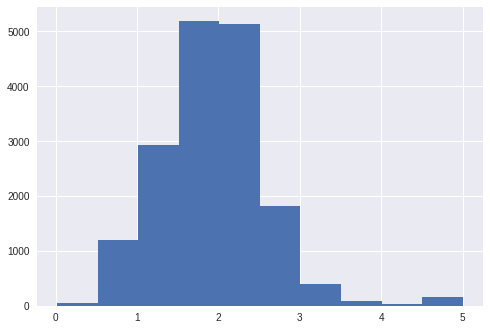

In [9]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

 Pour vérifier la réussite de cette opération, vous allez procéder à un nouvel apprentissage et imprimer à nouveau les données de calibrage :

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.08
  period 02 : 166.78
  period 03 : 147.25
  period 04 : 130.75
  period 05 : 119.51
  period 06 : 114.43
  period 07 : 110.54
  period 08 : 108.48
  period 09 : 108.49
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,193.0,207.3
std,50.6,116.0
min,44.7,15.0
25%,160.7,119.4
50%,193.1,180.4
75%,220.5,265.0
max,428.9,500.0


Final RMSE (on training data): 108.49


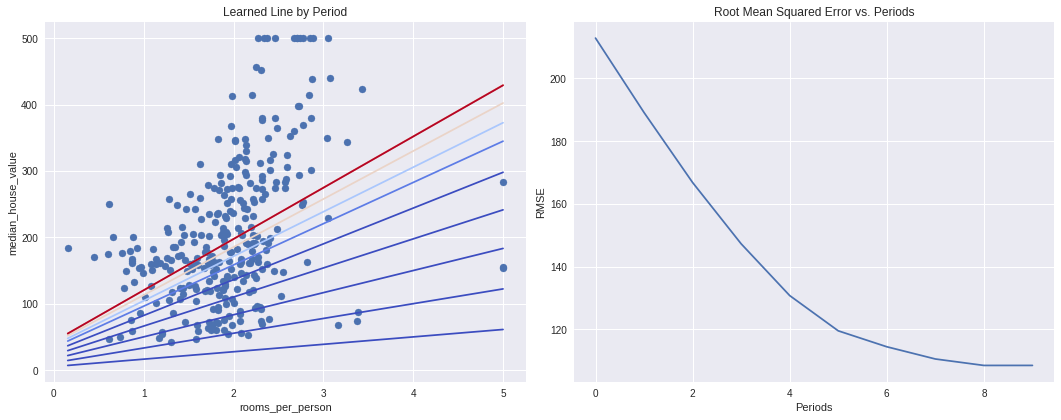

In [10]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

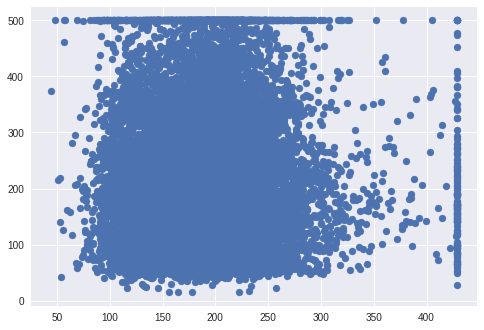

In [11]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])